In [1]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
    -O /tmp/bbc-text.csv

--2020-08-27 19:34:38--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [application/octet-stream]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.04s   

2020-08-27 19:34:38 (108 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



In [13]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

In [25]:
sentences = []
labels = []

In [5]:
import pandas as pd

data = pd.read_csv('/tmp/bbc-text.csv')
labels = list(data['category'])
sentences = list(data['text'])
    
print(len(labels))
print(len(sentences))
print(sentences[0])

2225
2225
tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-i

In [7]:
train_size = int(len(sentences)*training_portion)

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

1780
1780
1780
445
445


In [24]:
tokenizer = Tokenizer(num_words = vocab_size,
                      oov_token = oov_tok)

tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, 
                             maxlen = max_length,
                             padding = padding_type, 
                             truncating = trunc_type )

In [17]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, 
                                  maxlen = max_length,
                                  padding = padding_type, 
                                  truncating = trunc_type )

print(len(validation_sequences))
print(validation_padded.shape)

445
(445, 120)


In [23]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 150       
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [20]:
num_epochs = 30
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/30
56/56 - 0s - loss: 1.7684 - accuracy: 0.2236 - val_loss: 1.7358 - val_accuracy: 0.2382
Epoch 2/30
56/56 - 0s - loss: 1.6925 - accuracy: 0.2320 - val_loss: 1.6455 - val_accuracy: 0.2854
Epoch 3/30
56/56 - 0s - loss: 1.5854 - accuracy: 0.3820 - val_loss: 1.5272 - val_accuracy: 0.4404
Epoch 4/30
56/56 - 0s - loss: 1.4409 - accuracy: 0.4899 - val_loss: 1.3667 - val_accuracy: 0.5753
Epoch 5/30
56/56 - 0s - loss: 1.2539 - accuracy: 0.6034 - val_loss: 1.1775 - val_accuracy: 0.6292
Epoch 6/30
56/56 - 0s - loss: 1.0574 - accuracy: 0.6483 - val_loss: 1.0028 - val_accuracy: 0.6831
Epoch 7/30
56/56 - 0s - loss: 0.8906 - accuracy: 0.7500 - val_loss: 0.8677 - val_accuracy: 0.8000
Epoch 8/30
56/56 - 0s - loss: 0.7567 - accuracy: 0.8292 - val_loss: 0.7542 - val_accuracy: 0.8584
Epoch 9/30
56/56 - 0s - loss: 0.6473 - accuracy: 0.8893 - val_loss: 0.6655 - val_accuracy: 0.8607
Epoch 10/30
56/56 - 0s - loss: 0.5550 - accuracy: 0.9067 - val_loss: 0.5951 - val_accuracy: 0.8719
Epoch 11/30
56/56 -

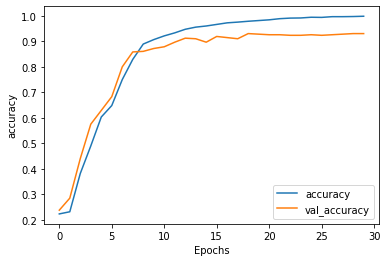

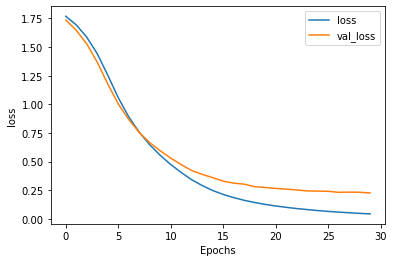

In [22]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")